### Custom embedder for parametric UMAP. 
This notebook shows you how to run a UMAP projection with a custom embedder. 

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

### load data

In [2]:
from torchvision import datasets, transforms

# Download and load the MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Convert PyTorch tensor to NumPy array
train_images = mnist_train.data.numpy()
train_labels = mnist_train.targets.numpy()
train_images = train_images.reshape((train_images.shape[0], -1))/255.
train_images.shape, train_labels.shape

((60000, 784), (60000,))

### define the encoder network

In [3]:
import keras

In [4]:
dims = (28, 28, 1)
n_components = 2
encoder = keras.Sequential([
    keras.layers.Input(shape=dims),
    keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dense(units=n_components, name="z"),
])
encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z (Dense)                       │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 888,194 (3.39 MB)

 Trainable params: 888,194 (3.39 MB)

 Non-trainable params: 0 (0.00 B)

### create parametric umap model

In [5]:
from umap.parametric_umap import ParametricUMAP

/n/groups/datta/tim_sainburg/conda_envs/parametricumap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
embedder = ParametricUMAP(
    encoder=encoder, 
    dims=dims, 
    n_components=n_components, 
    n_training_epochs=1, 
    verbose=True
)

In [ ]:
embedding = embedder.fit_transform(train_images)

ParametricUMAP(dims=(28, 28, 1), encoder=<Sequential name=sequential, built=True>)
Thu May 16 17:19:07 2024 Construct fuzzy simplicial set
Thu May 16 17:19:08 2024 Finding Nearest Neighbors
Thu May 16 17:19:08 2024 Building RP forest with 17 trees
Thu May 16 17:19:13 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Thu May 16 17:19:28 2024 Finished Nearest Neighbor Search
Thu May 16 17:19:31 2024 Construct embedding
Epoch 1/10
7797/7797 ━━━━━━━━━━━━━━━━━━━━ 522s 66ms/step - loss: 0.1969
Epoch 2/10
7797/7797 ━━━━━━━━━━━━━━━━━━━━ 467s 60ms/step - loss: 0.1773
Epoch 3/10
2884/7797 ━━━━━━━━━━━━━━━━━━━━ 4:49 59ms/step - loss: 0.1762

### plot results

In [11]:
embedding = embedder.embedding_

In [12]:
import matplotlib.pyplot as plt

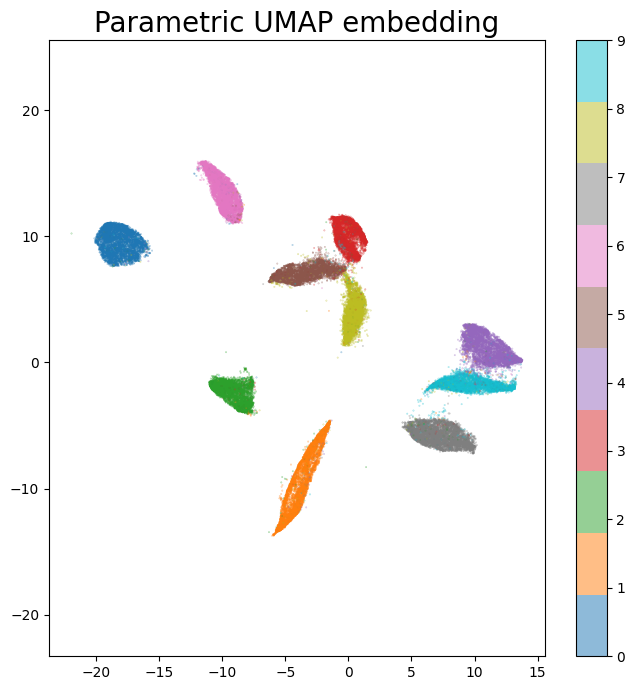

In [14]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=train_labels.astype(int),
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("Parametric UMAP embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### plotting loss

In [15]:
embedder._history.keys()

dict_keys(['loss'])

Text(0.5, 0, 'Epoch')

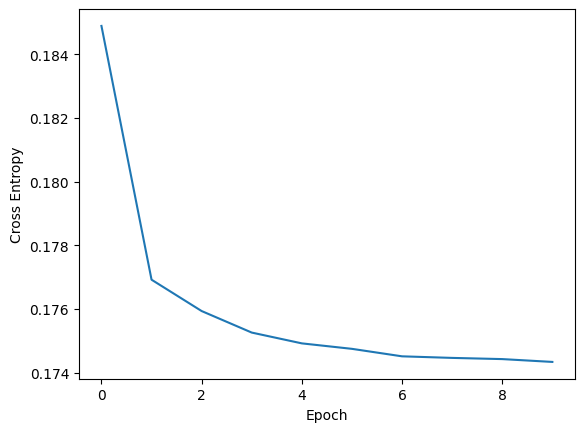

In [16]:
fig, ax = plt.subplots()
ax.plot(embedder._history['loss'])
ax.set_ylabel('Cross Entropy')
ax.set_xlabel('Epoch')

In [17]:
print('Done!')

Done!
